In [2]:
#Die ganzen packages die für den versuch verwendet werden

import numpy as np #numpy ist ein package mit allen mathematischen ausdrücken/funktionen/operationen/etc. 
from uncertainties import ufloat #Uncertainties ist für das automatische berrechnen von unsicherheiten
from uncertainties.umath import * #Importieren von rechnen mit uncertainties (addition/multiplikation/etc.)
from uncertainties import unumpy as unp #kann arrays von unsicherheiten verstehen (also eine liste, statt jede zahl einzeln einzutippen)
from IPython.display import Latex, HTML, Math, display # Um ergebnisse schöner anzuzeigen. display() "ersetzt" quasi print(), und lässt latex fromatierung zu
import matplotlib.pyplot as plt #Damit kann man graphen plotten

import pandas as pd #Um die Spektroskopie daten zu lesen
from scipy.signal import find_peaks #um die maxima von listen (also auch y-achse) zu finden


#funktion für mittwlert mit fehler defnieren (um später ein uarray mit unsicherheiten direkt zu einem mittelwert zu machen)
def mean(values):
    nom = unp.nominal_values(values)
    std_mean = np.std(nom, ddof=1) / np.sqrt(len(nom))
    return ufloat(np.mean(nom), std_mean)



In [3]:
#Farbige wellenlänge

#dieser code ist nur um Spektrum farbig zu machen

def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255
    factor = 0.0
    R = G = B = 0

    if 380 <= wavelength < 440:
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif 440 <= wavelength < 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 <= wavelength < 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 <= wavelength <= 780:
        R = 1.0
        G = 0.0
        B = 0.0

    if 380 <= wavelength < 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 380)
    elif 420 <= wavelength < 645:
        factor = 1.0
    elif 645 <= wavelength <= 780:
        factor = 0.3 + 0.7 * (780 - wavelength) / (780 - 645)

    R = ((R * factor) ** gamma)
    G = ((G * factor) ** gamma)
    B = ((B * factor) ** gamma)

    return (R, G, B)

# Brechung, Dispersion und Spektroskopie

## Dispersionskurve eines optischen Glases

Es wird die Disperionskurve eines Optischen Glases mittels Spektroskopie bestimmt.

### Grundlagen

### Durchführung und Aufbau

### Ergebnisse

Die mittels Goniometer bestimmten Minimal Winkel und den Dementsprechenden Brechungsindizes sind in Tabelle 1. angeführt.

In [4]:
#Goniometer: Spektrallinien einer Quecksilberlampe

#Spektrallinien Winkel:

# Unsicherheit vom winkel nach augenmaß (höher als auflösung vom goniometer = 0.01)
Winkel_std = 0.1
# Epsilon winkel vom Prisma:
e = 60

#                          Lila     Blau   Grün    Gelb
ungebrochen = unp.uarray([ 92.95 , 90.64 , 91.73 , 92.10 ], Winkel_std)
gebrochen   = unp.uarray([ 41.65 , 40.15 , 41.96 , 42.50  ], Winkel_std)

delta_min = ungebrochen - gebrochen
n_wert = unp.sin((delta_min + e)/2 * np.pi/180) / unp.sin(e/2 * np.pi/180) # * np.pi/180 weil np.sin nur mit Bogenmaß arbeitet (!!!nicht mit winkelmaß!!!)


n = unp.uarray(unp.nominal_values(n_wert), unp.std_devs(n_wert) + 0.01) # Unischerheit von n anpassen (in diesem falls + 0.01)


#----------------------------------------------------------------------------------------------------------------------------------------------
#
# Ab hier alles nur um die Tabellen schön darzustellen. Man könnte auch einfach print(n) und print(delta_min) machen ist aber uuuurrrr schirch
#
#----------------------------------------------------------------------------------------------------------------------------------------------


meine_lieblingsfarben = (["Lila", "Blau", "Grün", "Gelb"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Min. Winkel} ~\delta_{min}~\mathrm[°] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Delta,n_i) in enumerate(zip(meine_lieblingsfarben, delta_min, n)):
    table += rf"\mathrm{{{farbe}}} & ({Delta:.2f}) & ({n_i:.3f}) \\ "
table += r"\end{array}$$"

display(Latex(table))

<IPython.core.display.Latex object>

Spektrum der Quecksilberdampflampe

<IPython.core.display.Latex object>

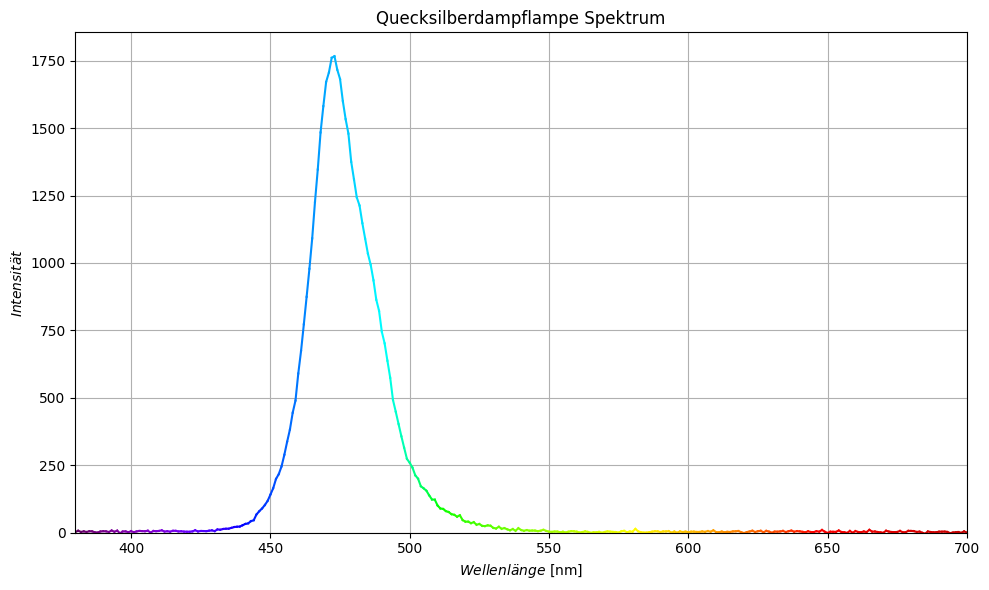

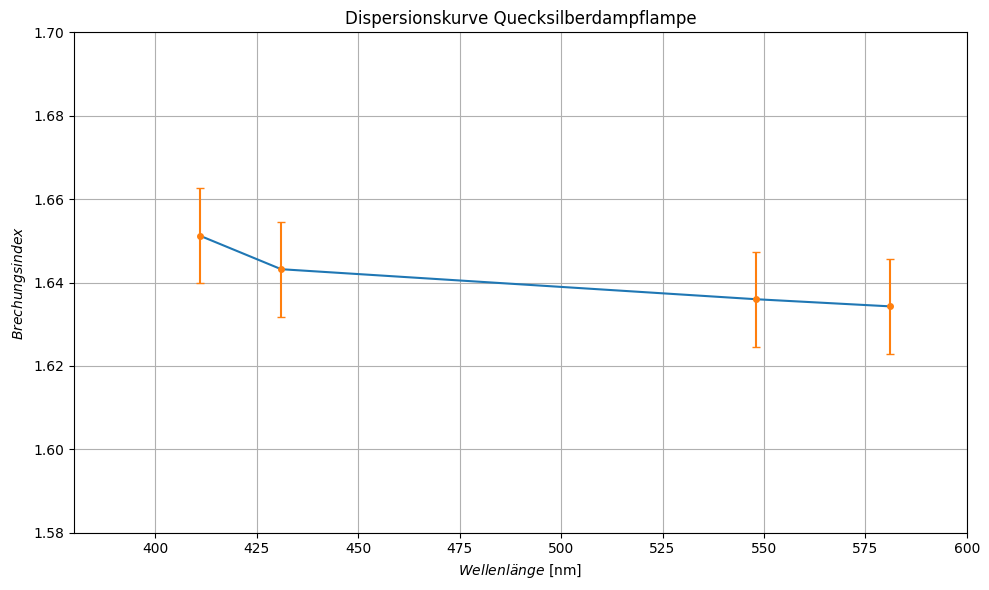

In [ ]:
#Spektrum der Quecksilberdampflampe


Spektrum = pd.read_csv("GPT-Data.csv", sep=',', decimal='.')

wellenlänge_wert = Spektrum['Wavelength'].values            #nm
wellenlänge = wellenlänge_wert
Int = Spektrum['Intensity'].values


# Create a color list for each wavelength
colors = [wavelength_to_rgb(wl) for wl in wellenlänge]

# Plot with color gradient
plt.figure(figsize=(10, 6))
for i in range(len(wellenlänge) - 1):
    plt.plot(wellenlänge[i:i+2], Int[i:i+2], color=colors[i])

plt.xlabel("$Wellenlänge$ [nm]")
plt.ylabel("$Intensität$")
plt.title("Quecksilberdampflampe Spektrum")
plt.ylim(bottom=-0.1)
plt.xlim(left=380, right=700)
plt.grid()
plt.tight_layout()

ranges = [(380, 415), (420, 450), (540, 550), (580, 600)]
peak_positions = []
peak_values = []


#Die maxima aus den Daten bestimmen
for r in ranges:
    mask = (wellenlänge >= r[0]) & (wellenlänge < r[1])
    peaks, _ = find_peaks(Int[mask])
    if len(peaks) > 0:
        # get index of highest peak in this range
        local_max_idx = peaks[np.argmax(Int[mask][peaks])]
        peak_positions.append(wellenlänge[mask][local_max_idx])
        peak_values.append(Int[mask][local_max_idx])

meine_lieblingsfarben = (["Lila", "Blau", "Grün", "Gelb"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Wellenlänge} ~\lambda~\mathrm[nm] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Peak,n_i) in enumerate(zip(meine_lieblingsfarben, peak_positions, n)):
    table += rf"\mathrm{{{farbe}}} & ({Peak:.2f}) & ({n_i:.3f}) \\ "
table += r"\end{array}$$"

display(Latex(table))

plt.figure(figsize=(10, 6))
plt.plot(peak_positions, unp.nominal_values(n))
plt.xlabel("$Wellenlänge$ [nm]")
plt.ylabel("$Brechungsindex$")
plt.errorbar(peak_positions, unp.nominal_values(n), fmt='o',yerr=unp.std_devs(n), capsize=3, markersize=4,label="Messdaten")
plt.title("Dispersionskurve Quecksilberdampflampe")
plt.ylim(bottom=1.58, top=1.70)
plt.xlim(left=380, right=600)
plt.grid()
plt.tight_layout()
plt.show()


## Absorptionsspektrum

In [ ]:
# Praseodym-Daten
lambda_praseodym = np.array([444, 468, 481, 590])  # Literaturwerte [nm]

# Maxima
messwerte = np.array([434, 468, 481, 590])         # OceanView
messwerte_u = unp.uarray([434, 468, 481, 590], [3, 4, 5, 7])  # mit Unsicherheit


abweichung = messwerte - lambda_praseodym


Meine_zweit_liebsten_farben = np.array(["blau", "türkisblau", "türkis", "gelborange"])

table = r"""$$
\begin{array}{c|c|c|c}
\textbf{Farbe} & \textbf{$\lambda_\text{Lit}$ [nm]} & \textbf{$\lambda_\text{gemessen}$ [nm]} & \textbf{Abweichung [nm]} \\ \hline
"""

for farbe, lam_lit, lam_meas, diff in zip(Meine_zweit_liebsten_farben, lambda_praseodym, messwerte_u, abweichung):
    lam_meas_str = f"{lam_meas.n:.0f} ± {lam_meas.s:.0f}"
    table += rf"\mathrm{{{farbe}}} & {lam_lit:.0f} & {lam_meas_str} & {diff:.0f} \\ " + "\n"

table += r"\end{array}$$"

display(Latex(table))


<IPython.core.display.Latex object>